<h1>개인 구글 드라이브와 colab 연동</h1>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
!pip install transformers
!pip install torch==1.10.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.10.2 which is incompatible.
torchtext 0.14.1 requires torch==1.13.1,

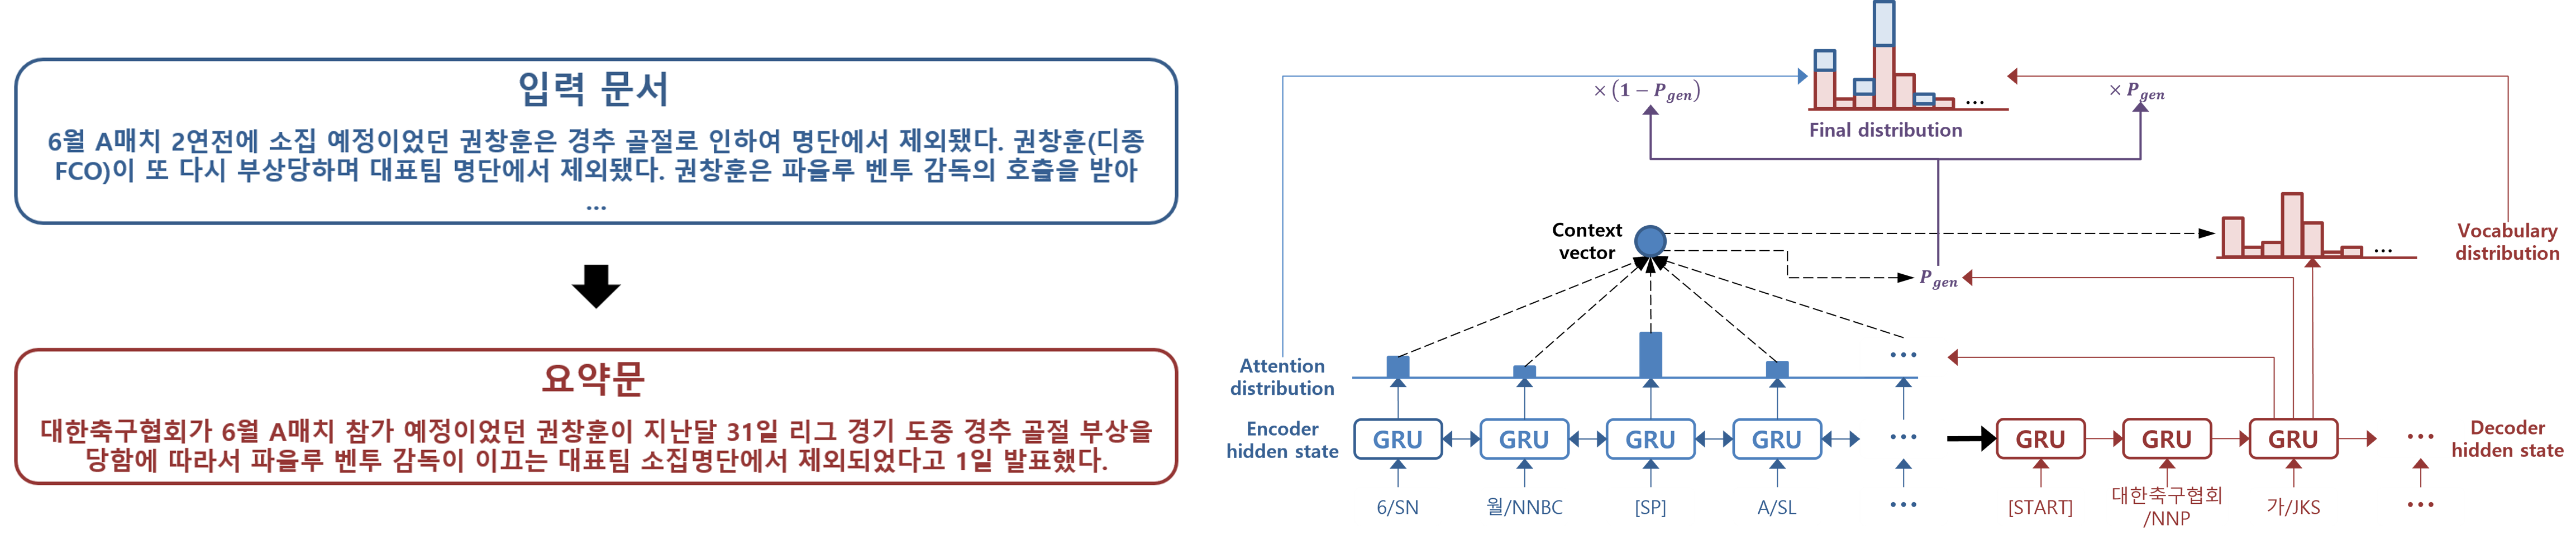

In [3]:
from IPython.display import Image
import os

# 코드와 데이터가 있는 구글 드라이브상의 경로
root_dir = "/gdrive/MyDrive/colab/pointer_generator"
Image(os.path.join(root_dir, "Pointer_Generator.png"))

<h1>Pointer Generator 기반 요약 모델</h1>



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Encoder(nn.Module):
    def __init__(self, embedding, embedding_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()

        # 임베딩 함수
        self.embedding = embedding

        # BI-GRU 계층
        self.bi_gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size,
                             num_layers=1, batch_first=True, bidirectional=True)

        # 드랍아웃
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_features):
        # input_features : (batch_size, enc_max_len)

        # input_lengths : (batch_size,)
        input_lengths = (input_features != 0).sum(dim=-1)

        # input_embeddings : (batch_size, enc_max_len, embedding_size)
        input_embeddings = self.embedding(input_features)

        packed_input_features = pack_padded_sequence(input=input_embeddings, lengths=input_lengths.cpu(),
                                                     batch_first=True, enforce_sorted=False)
        # rnn_hidden : (2, batch_size, hidden_size)
        packed_rnn_outputs, rnn_hidden = self.bi_gru(packed_input_features)
        # rnn_outputs : (batch_size, curr_max_len, hidden_size)
        rnn_outputs, input_lengths = pad_packed_sequence(sequence=packed_rnn_outputs, batch_first=True)

        # (2, batch_size, hidden_size) -> (batch_size, hidden_size*2)
        rnn_hidden = torch.cat(tensors=(rnn_hidden[0], rnn_hidden[1]), dim=-1)

        # rnn_outputs : (batch_size, curr_max_len, hidden_size)
        # rnn_hidden : (batch_size, hidden_size*2)
        rnn_outputs, rnn_hidden = self.dropout(rnn_outputs), self.dropout(rnn_hidden)

        return rnn_outputs, rnn_hidden


class Decoder(nn.Module):
    def __init__(self, embedding, embedding_size, hidden_size, vocab_size, dropout_rate, unk_token_id):
        super(Decoder, self).__init__()

        self.embedding = embedding
        self.vocab_size = vocab_size
        self.unk_token_id = unk_token_id

        self.cover_weight = nn.Parameter(torch.rand(1))
        self.eps = 1e-31

        # GRU 계층
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=1, batch_first=True)

        self.ptr_linear = nn.Linear(in_features=hidden_size * 2, out_features=1)

        self.gen_linear_1 = nn.Linear(in_features=hidden_size * 2, out_features=hidden_size)
        self.gen_linear_2 = nn.Linear(in_features=hidden_size, out_features=vocab_size)

        self.dropout = nn.Dropout(dropout_rate)

    def filter_oov(self, input, ext_vocab_size):
        # OOV에 대응하는 index를 [UNK] 토큰 index로 치환
        if ext_vocab_size > self.vocab_size:
            new_input = input.clone()
            new_input[input >= self.vocab_size] = self.unk_token_id
            return new_input
        else:
            return input

    def forward(self, decoder_input, decoder_hidden, coverage_vector, input_features, encoder_outputs, ext_vocab_size):
        # decoder_input : (batch_size, )
        # decoder_hidden (prev step) : (1, batch_size, hidden_size)
        # encoder_outputs : (batch_size, curr_max_len, hidden_size)

        batch_size = decoder_input.size(0)

        # (batch_size, ) -> (batch_size, embedding_size) -> (batch_size, 1, embedding_size)
        decoder_input = self.embedding(self.filter_oov(input=decoder_input,
                                                       ext_vocab_size=ext_vocab_size)).unsqueeze(1)

        # rnn_output : (batch_size, 1, hidden_size)
        # rnn_hidden : (1, batch_size, hidden_size)
        rnn_output, rnn_hidden = self.gru(decoder_input, decoder_hidden)

        # (batch_size, 1, curr_max_length)
        attn_weights = rnn_output.bmm(encoder_outputs.transpose(1, 2).contiguous())
        if coverage_vector != None:
            attn_weights += self.cover_weight * torch.log(coverage_vector.unsqueeze(1) + self.eps)
        
        attn_weights = F.softmax(attn_weights, dim=-1)

        # (batch_size, 1, hidden_size)
        context = attn_weights.bmm(encoder_outputs)

        # rnn_output : (1, batch_size, hidden_size) -> (batch_size, hidden_size)
        # context : (batch_size, 1, hidden_size) -> (batch_size, hidden_size)
        rnn_output, context = rnn_output.squeeze(1), context.squeeze(1)

        # (batch_size, hidden_size*2)
        combined = torch.cat(tensors=[rnn_output, context], dim=-1)

        # pointer
        # (batch size, 1)
        prob_ptr = torch.sigmoid(self.ptr_linear(combined))
        # (batch_size, 1, curr_max_length) -> (batch_size, curr_max_length)
        ptr_output = attn_weights.squeeze(1)

        # generator
        prob_gen = 1 - prob_ptr
        # (batch_size, hidden_size*2) -> (batch_size, hidden_size)
        gen_output = torch.tanh(self.gen_linear_1(combined))
        # (batch_size, hidden_size) -> (batch_size, vocab_size)
        gen_output = F.softmax(self.gen_linear_2(gen_output), dim=-1)

        # ptr_output과 gen_output 통합
        output = torch.zeros(size=(batch_size, ext_vocab_size), dtype=torch.float, device=gen_output.device)
        output[:, :self.vocab_size] = prob_gen * gen_output
        output.scatter_add_(dim=1, index=input_features, src=prob_ptr * ptr_output)

        return output, rnn_hidden, ptr_output, prob_ptr


class PointerGenerator(nn.Module):
    def __init__(self, config):
        super(PointerGenerator, self).__init__()

        # 형태소 어휘 사전 크기
        self.vocab_size = config["vocab_size"]

        # [UNK] 토큰 index
        self.unk_token_id = config["unk_token_id"]

        # 인코더 최대 길이
        self.enc_max_len = config["enc_max_len"]

        # 디코더 최대 길이
        self.dec_max_len = config["dec_max_len"]
        self.eps = 1e-31

        # 데이터의 각 형태소 index를 대응하는 임베딩 벡터로 치환하기 위한 임베딩 함수
        # 기존에 사전학습 된 단어 임베딩을 사용할 수도 있고 랜덤으로 초기화 한 후,
        # 모델 학습 과정 중에 같이 학습 시키는 것도 가능
        # 예제 코드는 랜덤으로 초기화 한 후 같이 학습하도록 설정
        self.embedding = nn.Embedding(num_embeddings=config["vocab_size"],
                                      embedding_dim=config["embedding_size"],
                                      padding_idx=0)

        # 인코더
        self.encoder = Encoder(embedding=self.embedding, embedding_size=config["embedding_size"],
                               hidden_size=config["hidden_size"], dropout_rate=config["dropout_rate"])

        # 디코더
        self.decoder = Decoder(embedding=self.embedding, embedding_size=config["embedding_size"],
                               hidden_size=config["hidden_size"]*2, vocab_size=config["vocab_size"],
                               dropout_rate=config["dropout_rate"], unk_token_id=self.unk_token_id)

        self.dropout = nn.Dropout(config["dropout_rate"])

        self.teacher_forcing_rate = config["teacher_forcing_rate"]

    def filter_oov(self, input, ext_vocab_size):
        # OOV에 대응하는 index를 [UNK] 토큰 index로 치환
        if ext_vocab_size > self.vocab_size:
            new_input = input.clone()
            new_input[input >= self.vocab_size] = self.unk_token_id
            return new_input
        else:
            return input

    def forward(self, input_features, output_features=None, ext_vocab_size=None):
        # input_features, output_features : (batch_size, enc_max_len), (batch_size, dec_max_len)
        batch_size = input_features.size(0)

        # encoder_outputs : (batch_size, curr_max_len, hidden_size)
        # encoder_hidden : (batch_size, hidden_size*2)
        encoder_outputs, encoder_hidden = self.encoder(input_features=self.filter_oov(input=input_features,
                                                                                      ext_vocab_size=ext_vocab_size))

        curr_enc_max_len = encoder_outputs.size(1)

        # (batch_size, max_len) -> (batch_size, curr_max_len)
        input_features = input_features[:, :curr_enc_max_len]

        # (batch_size, ), 디코더의 시작 step 입력 값을 "[START]"로 초기화
        decoder_input = torch.ones(size=(batch_size, ), dtype=torch.long, device=input_features.device)
        # (batch_size, hidden_size) -> (1, batch_size, hidden_size)
        decoder_hidden = encoder_hidden.unsqueeze(0)
        decoder_outputs, enc_attn_weights = [], []
        if (output_features is not None):
            loss_func = nn.NLLLoss(ignore_index=0)

            loss = None
            for step in range(self.dec_max_len):
                coverage_vector = torch.sum(torch.cat(enc_attn_weights), dim=0) if enc_attn_weights else None

                # decoder_output : (batch_size, ext_vocab_size)
                # decoder_hidden : (1, batch_size, hidden_size*2)
                # ptr_output : (batch_size, curr_max_len)
                # prob_ptr : (batch_size, 1)
                decoder_output, decoder_hidden, ptr_output, prob_ptr = self.decoder(decoder_input=decoder_input,
                                                                                    decoder_hidden=decoder_hidden,
                                                                                    coverage_vector=coverage_vector,
                                                                                    input_features=input_features,
                                                                                    encoder_outputs=encoder_outputs,
                                                                                    ext_vocab_size=ext_vocab_size)
                decoder_output = torch.log(decoder_output + self.eps)

                if loss == None:
                    loss = loss_func(decoder_output, output_features[:, step])
                else:
                    loss += loss_func(decoder_output, output_features[:, step])

                if coverage_vector != None:
                    coverage_loss = torch.sum(torch.min(coverage_vector, ptr_output)) / batch_size
                    loss += coverage_loss

                if random.random() < self.teacher_forcing_rate:
                    decoder_input = output_features[:, step]
                else:
                    decoder_input = torch.argmax(decoder_output, dim=-1)

                decoder_outputs.append(decoder_output)
                enc_attn_weights.append(ptr_output.unsqueeze(0))

            return loss
        else:

            decoder_outputs, enc_attn_weights = [], []
            for step in range(self.dec_max_len):

                coverage_vector = torch.sum(torch.cat(enc_attn_weights), dim=0) if enc_attn_weights else None

                # decoder_output : (batch_size, ext_vocab_size)
                # decoder_hidden : (1, batch_size, hidden_size*2)
                # ptr_output : (batch_size, curr_max_len)
                # prob_ptr : (batch_size, 1)
                decoder_output, decoder_hidden, ptr_output, prob_ptr = self.decoder(decoder_input=decoder_input,
                                                                                    decoder_hidden=decoder_hidden,
                                                                                    coverage_vector=coverage_vector,
                                                                                    input_features=input_features,
                                                                                    encoder_outputs=encoder_outputs,
                                                                                    ext_vocab_size=ext_vocab_size)
                decoder_output = torch.log(decoder_output + self.eps)
                decoder_input = torch.argmax(decoder_output, dim=-1)

                decoder_outputs.append(decoder_output)
                enc_attn_weights.append(ptr_output.unsqueeze(0))

            # (max_length, batch_size, vocab_size)
            decoder_outputs = torch.stack(tensors=decoder_outputs, dim=0)
            # (max_length, batch_size, vocab_size) -> (batch_size, max_length, vocab_size)
            decoder_outputs = decoder_outputs.transpose(0, 1)

            return decoder_outputs

<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. read_data(file_path)</b>
  "train_datas.json", "test_datas.json" 파일을 읽기 위한 함수
  
  데이터 예시)
    "document": "11/SN ~/SY 24/SN 일/NNBC ,/SC [SP] 매실/NNG ·/SC 감/NNG ·/SC 참/IC 다래/NNP [SP] 등/NNG [SP] 지역/NNG
                특화/NNG 작목/NNG [SP] 이성훈/NNP [SP] sinawi/SL @/SY hanmail/SL ./SY net/SL [SP] 광양시/NNP 는/JX [SP]
                오/VV 는/ETM [SP] 11/SN 일/NNBC 부터/JX [SP] 24/SN 일/NNBC 까지/JX [SP] 농업/NNG 인교/NNG 육관/NNG 과/JC
                [SP] 읍/IC 면/NNG 동/NNG [SP] 회의실/NNG 에서/JKB [SP] 농업/NNG 인/VCP+ETM [SP] 1050/SN 명/NNBC 을/JKO
                [SP] 대상/NNG 으로/JKB [SP] 새해/NNG [SP] 농업/NNG 인/VCP+ETM [SP] 실용/NNG 교육/NNG 을/JKO [SP] 실시/NNG 한
                ...
    "summary": "광양시/NNP 는/JX [SP] 농업/NNG 인/XSN 들/XSN 의/JKB [SP] 경쟁력/NNG 을/JKO [SP] 높이/VV 고/EC ,/SC [SP]
                소득/NNG 안정/NNG 을/JKO [SP] 위해/VV+EC [SP] 매실/NNG ·/SC 감/NNG ·/SC 참/IC 다래/NNP [SP] 등/NNG [SP]
                지역/NNG 특화/NNG 작목/NNG [SP] 중심/NNG 으로/JKB [SP] 농업/NNG 인/VCP+ETM [SP] 실용/NNG 교육/NNG 을/JKO
                [SP] 실시/NNG 한다/XSV+EF ./SF"
  
  read_data(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    datas : 문서와 대응하는 요약문을 담고 있는 리스트

      
<b>2. read_vocab_data(vocab_data_path)</b>
  "vocab.txt" 파일을 읽고 형태소를 indexing하기 위한 딕셔너리를 생성
   
  read_vocab_data(vocab_data_path)
  args
    vocab_data_path : 어휘 파일 경로
  return  
    mor2idx : 형태소를 대응하는 index로 치환하기 위한 딕셔너리
    idx2mor : index를 대응하는 형태소로 치환하기 위한 딕셔너리

    
<b>3. convert_data2feature(datas, enc_max_len, dec_max_len, mor2idx)</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  OOV 어휘에 대한 정보를 담고 있는 딕셔너리 생성
  Tensor로 변환
   
  convert_data2feature(datas, enc_max_len, dec_max_len, mor2idx)
  args
    datas : 문서와 대응하는 요약문을 담고 있는 리스트
    enc_max_len : 인코더 입력 최대 길이
    dec_max_len : 디코더 출력 최대 길이
    mor2idx : 형태소를 대응하는 index로 치환하기 위한 딕셔너리
  return
    data_ids : 각 데이터에 대한 id 정보를 담고 있는 Tensor 객체
    input_features : index로 치환된 문서 데이터를 담고 있는 Tensor 객체
    output_features : index로 치환된 요약 데이터를 담고 있는 Tensor 객체
    oov_vocab : 각 데이터에 대한 OOV 어휘에 대한 정보를 갖고 있는 딕셔너리
    
 </pre>


In [5]:
import json
import torch
import numpy as np
from tqdm import tqdm

# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        datas = json.load(inFile)
    return datas

def read_vocab_data(file_path):

    mor2idx, idx2mor = {}, {}
    with open(file_path, "r", encoding="utf8") as inFile:
        for line in inFile.readlines():
            morpheme = line.strip()

            mor2idx[morpheme] = len(mor2idx)
            idx2mor[mor2idx[morpheme]] = morpheme

    return mor2idx, idx2mor


# 데이터 전처리
def convert_data2feature(datas, enc_max_len, dec_max_len, mor2idx):
    # 데이터 ID, 입력 데이터, 출력 데이터를 담을 리스트
    data_ids, input_features, output_features = [], [], []
    # OOV 사전
    oov_vocab = {}

    # 기본 어휘 사전의 크기
    base_vocab_size = len(mor2idx)
    for data_index, data in tqdm(enumerate(datas), desc="convert_data2feature", total=len(datas)):
        document, summary = data["document"], data["summary"]
        doc_morphemes, sum_morphemes = document.split()[:enc_max_len], summary.split()[:dec_max_len - 1]
        oov_vocab[data_index], ext_vocab_size = {"mor2idx":{}, "idx2mor":{}, "ext_vocab_size":0}, base_vocab_size

        # 문서에 대한 전처리
        input_ids = []
        for mor in doc_morphemes:
            # 형태소가 어휘 사전에 존재하는 경우
            if mor in mor2idx:
                input_ids.append(mor2idx[mor])
            # 형태소가 어휘 사전에 존재하지 않는 경우
            else:
                # 형태소가 OOV 사전에 존재하는 경우
                if mor in oov_vocab[data_index]["mor2idx"]:
                    ext_idx = oov_vocab[data_index]["mor2idx"][mor]
                # 형태소가 OOV 사전에 존재하지 않는 경우
                else:
                    ext_idx = ext_vocab_size
                    oov_vocab[data_index]["mor2idx"][mor] = ext_idx
                    oov_vocab[data_index]["idx2mor"][ext_idx] = mor
                    ext_vocab_size += 1
                input_ids.append(ext_idx)
        oov_vocab[data_index]["ext_vocab_size"] = ext_vocab_size
        assert base_vocab_size + len(oov_vocab[data_index]["mor2idx"]) == ext_vocab_size

        # 요약에 대한 전처리
        output_ids = []
        for mor in sum_morphemes:
            # 형태소가 어휘 사전에 존재하는 경우
            if mor in mor2idx:
                output_ids.append(mor2idx[mor])
            # 형태소가 어휘 사전에 존재하지 않는 경우
            else:
                if mor in oov_vocab[data_index]["mor2idx"]:
                    output_ids.append(oov_vocab[data_index]["mor2idx"][mor])
                else:
                    output_ids.append(mor2idx["[UNK]"])
        output_ids.append(mor2idx["[END]"])

        input_padding_ids = [0] * (enc_max_len - len(input_ids))
        output_padding_ids = [0] * (dec_max_len - len(output_ids))

        input_ids += input_padding_ids
        output_ids += output_padding_ids

        # 변환한 데이터를 각 리스트에 저장
        data_ids.append(data_index)
        input_features.append(input_ids)
        output_features.append(output_ids)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    data_ids = torch.tensor(data_ids, dtype=torch.long)
    input_features = torch.tensor(input_features, dtype=torch.long)
    output_features = torch.tensor(output_features, dtype=torch.long)

    return data_ids, input_features, output_features, oov_vocab

<h1>Pointer Generator 모델 학습</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, enc_max_len, dec_max_len, mor2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. Pointer Generator 모델 객체 선언</b>

<b>5. epoch를 돌때마다 Loss가 감소한 경우에만 모델 파일 저장</b>
</pre>

In [6]:
import numpy as np
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler)


def train(config):
    # 어휘 사전 읽기
    mor2idx, idx2mor = read_vocab_data(file_path=config["vocab_data_path"])

    # 학습 데이터 읽기
    train_datas = read_data(file_path=config["train_data_path"])

    # 입력 데이터 전처리
    train_data_ids, train_input_features, train_output_features, train_oov_vocab = convert_data2feature(datas=train_datas,
                                                                                                        enc_max_len=config["enc_max_len"],
                                                                                                        dec_max_len=config["dec_max_len"],
                                                                                                        mor2idx=mor2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_data_ids, train_input_features, train_output_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features), batch_size=config["batch_size"])

    t_total = len(train_dataloader) * config["epoch"]

    deep_model = PointerGenerator(config=config).cuda()

    # 모델 학습을 위한 optimizer
    optimizer = AdamW(deep_model.parameters(), lr=config["learning_rate"])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=t_total)

    # 모델의 정확도를 저장하기 위한 변수
    min_average_loss = 10000
    for epoch in range(config["epoch"]):
        deep_model.train()

        losses = []
        for step, batch in enumerate(tqdm(train_dataloader, desc="train_epoch_{}".format(epoch + 1))):
            batch = tuple(t.cuda() for t in batch)

            # 입력 데이터, 출력 데이터
            data_ids, input_ids, output_ids = batch[0], batch[1], batch[2]

            data_ids = data_ids.cpu().detach().numpy().tolist()
            curr_ext_vocab_size = max([train_oov_vocab[_id]["ext_vocab_size"] for _id in data_ids])

            # 모델 학습
            loss = deep_model(input_features=input_ids, output_features=output_ids, ext_vocab_size=curr_ext_vocab_size)

            if config["gradient_accumulation_steps"] > 1:
                loss = loss / config["gradient_accumulation_steps"]

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()
            if (step + 1) % config["gradient_accumulation_steps"] == 0:
                # 모델 내부 각 매개변수 가중치 갱신
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            # batch 단위 loss 값 저장
            losses.append(loss.data.item())

        average_loss = round(np.mean(losses), 4)

        # 현재의 정확도가 기존 정확도보다 높은 경우 모델 파일 저장
        if (min_average_loss > average_loss):
            min_average_loss = average_loss

            torch.save(deep_model.state_dict(), os.path.join(config["output_dir"], "trained_model.pt"))

        # epoch 별로 평균 loss 값과 정확도 출력
        print("Average loss : {}\n".format(average_loss))

<h1>Pointer Generator 모델 평가</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, enc_max_len, dec_max_len, mor2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. Pointer Generator 모델 객체 선언</b>

<b>5. load_state_dict() 함수를 사용하여 학습한 모델 파일로부터 가중치를 불러옴</b>

<b>6. show_model_predict(datas, id2pred_sen) 함수를 사용하여 모델의 요약 결과 확인</b>
</pre>

In [7]:
import re
import torch
from tqdm import tqdm
from torch.utils.data import (DataLoader, TensorDataset, SequentialSampler)


def test(config):
    # 어휘 사전 읽기
    mor2idx, idx2mor = read_vocab_data(file_path=config["vocab_data_path"])

    # 평가 데이터 읽기
    test_datas = read_data(file_path=config["test_data_path"])

    # 데이터 전처리
    test_data_ids, test_input_features, test_output_features, test_oov_vocab = convert_data2feature(datas=test_datas,
                                                                                                    enc_max_len=config["enc_max_len"],
                                                                                                    dec_max_len=config["dec_max_len"],
                                                                                                    mor2idx=mor2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_data_ids, test_input_features, test_output_features)
    dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    deep_model = PointerGenerator(config=config)
    deep_model.load_state_dict(torch.load(os.path.join(config["save_dir"], "trained_model.pt")))
    deep_model.cuda()

    deep_model.eval()
    total_ids, predicts = [], []
    for step, batch in enumerate(tqdm(dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)

        # 입력 데이터, 출력 데이터
        data_ids, input_ids, output_ids = batch[0], batch[1], batch[2]

        data_ids = data_ids.cpu().detach().numpy().tolist()
        total_ids += data_ids

        curr_ext_vocab_size = max([test_oov_vocab[_id]["ext_vocab_size"] for _id in data_ids])

        # 모델 학습
        outputs = deep_model(input_features=input_ids, ext_vocab_size=curr_ext_vocab_size)
        outputs = torch.argmax(outputs, dim=-1)
        outputs = outputs.detach().cpu().numpy().tolist()

        predicts += outputs

    assert len(total_ids) == len(predicts)
    id2predicts = {}
    for index in range(len(total_ids)):
        _id, predict = total_ids[index], predicts[index]
        id2predicts[_id] = predict

    test_id2pred_sen = data_postprocessing(id2predicts=id2predicts, idx2mor=idx2mor, oov_vocab=test_oov_vocab)

    show_model_predict(datas=test_datas, id2pred_sen=test_id2pred_sen)


def show_model_predict(datas, id2pred_sen):

    for data_index, data in enumerate(datas[:10]):
        document, summary = data["document"], data["summary"]
        doc_mors, sum_mors = document.split(), summary.split()

        doc_words = [piece[:piece.rfind("/")] if "/" in piece else piece for piece in doc_mors]
        document = "".join(doc_words)
        document = re.sub("\[SP]", " ", document)

        sum_words = [piece[:piece.rfind("/")] if "/" in piece else piece for piece in sum_mors]
        summary = "".join(sum_words)
        summary = re.sub("\[SP]", " ", summary)

        pred_summary = id2pred_sen[data_index]

        print("문서 : {}".format(document))
        print("정답 요약 : {}".format(summary))
        print("출력 요약 : {}".format(pred_summary))
        print()

def data_postprocessing(id2predicts, idx2mor, oov_vocab):

    id2pred_sen = {}
    for _id, predict in id2predicts.items():
        oov_idx2mor = oov_vocab[_id]["idx2mor"]

        pred_mors = []
        for pred_idx in predict:
            if pred_idx in idx2mor:
                pred_mors.append(idx2mor[pred_idx])
            else:
                pred_mors.append(oov_idx2mor[pred_idx])

        if "[END]" in pred_mors:
            pred_mors = pred_mors[:pred_mors.index("[END]")]

        pred_words = [piece[:piece.rfind("/")] if "/" in piece else piece for piece in pred_mors]
        pred_sen = "".join(pred_words)
        pred_sen = re.sub("\[SP]", " ", pred_sen)

        id2pred_sen[_id] = pred_sen

    return id2pred_sen

In [ ]:
import os
import random
import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if(__name__=="__main__"):
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    set_seed(seed=1234)

    config = {"mode": "train",
              "vocab_data_path": os.path.join(root_dir, "vocab.txt"),
              "train_data_path": os.path.join(root_dir, "train_datas.json"),
              "test_data_path": os.path.join(root_dir, "test_datas.json"),
              "save_dir": save_dir,
              "output_dir": output_dir,
              "vocab_size":10004,
              "embedding_size":256,
              "hidden_size":256,
              "dropout_rate":0.1,              
              "teacher_forcing_rate":0.5,
              "unk_token_id":3,
              "learning_rate": 1e-3,
              "enc_max_len": 500,
              "dec_max_len": 200,
              "epoch": 50,
              "batch_size": 16,
              "gradient_accumulation_steps":4
              }

    if (config["mode"] == "train"):
        train(config)
    else:
        test(config)

convert_data2feature: 100%|██████████| 4289/4289 [00:00<00:00, 4752.53it/s]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
train_epoch_1:   2%|▏         | 6/269 [00:04<03:39,  1.20it/s]